# Hiking Trail Time predictor

Goal: Use a database of hiking trails with various parameters to predict the average walking time. 

## Table of contents
1. [Introduction](#intro)
2. [Dataset](#dataset)
3. [Loading modules and data](#loading)
4. [Data pre-processing](#pre-process)


# Introduction <a name="intro"></a>

# Dataset <a name="dataset"></a>

# Loading modules and data <a name="loading"></a>

In [1]:
import sys
import warnings
from urllib.parse import urlparse
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# model
from sklearn.model_selection import train_test_split

# mlflow
import mlflow
import mlflow.sklearn


/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.
  from ipykernel import kernelapp as app


In [2]:
df=pd.read_csv("gpx-tracks-from-hikr.org.csv")

In [3]:
df.head(3)

,_id,length_3d,user,start_time,max_elevation,bounds,uphill,moving_time,end_time,max_speed,gpx,difficulty,min_elevation,url,downhill,name,length_2d
0,5afb229e8f80884aaad9c6ea,10832.953016,Bergfritz,2018-05-11 07:37:40,1934.47,"{'min': {'type': 'Point', 'coordinates': [13.2...",612.880,12155.0,2018-05-11 11:38:23,1.595493,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<gpx x...",T2 - Mountain hike,1322.96,http://www.hikr.org/tour/post131855.html,609.670,"Remsteinkopf, 1945 m",10832.953016
1,5afb229e8f80884aaad9c6eb,12259.376315,Bergfritz,2018-05-12 07:25:08,2186.21,"{'min': {'type': 'Point', 'coordinates': [13.1...",614.753,13876.0,2018-05-12 12:08:28,1.394320,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<gpx x...",T3 - Difficult Mountain hike,1266.40,http://www.hikr.org/tour/post131856.html,1193.733,"Schuhflicker, 2214 m",12259.376315
2,5afb229e8f80884aaad9c6ec,22980.168081,igor,2018-05-11 06:29:38,2265.00,"{'min': {'type': 'Point', 'coordinates': [8.99...",2255.976,28971.0,2018-05-11 15:32:43,1.503002,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<gpx x...",T3 - Difficult Mountain hike,176.54,http://www.hikr.org/tour/post131839.html,2177.626,Cima d'erbea Est quota 2164m e Gaggio 2267m,22980.168081


In [4]:
df.columns

Index(['_id', 'length_3d', 'user', 'start_time', 'max_elevation', 'bounds',
       'uphill', 'moving_time', 'end_time', 'max_speed', 'gpx', 'difficulty',
       'min_elevation', 'url', 'downhill', 'name', 'length_2d'],
      dtype='object')

In [5]:
df.shape

(12141, 17)

# Data pre-processing <a name="pre-process"></a>

We can immediately drop some columns that won't be useful

In [6]:
df=df.drop(['_id','bounds','gpx','name','start_time','end_time','url','max_speed'],axis=1)

In [7]:
df.shape

(12141, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12141 entries, 0 to 12140
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   length_3d      12141 non-null  float64
 1   user           12141 non-null  object 
 2   max_elevation  10563 non-null  float64
 3   uphill         12141 non-null  float64
 4   moving_time    12141 non-null  float64
 5   difficulty     12141 non-null  object 
 6   min_elevation  10563 non-null  float64
 7   downhill       12141 non-null  float64
 8   length_2d      12141 non-null  float64
dtypes: float64(7), object(2)
memory usage: 853.8+ KB


Let's convert the difficulty into a number for easier use. First we can investigate the current difficulty ratings.

In [9]:
np.unique(df.difficulty)

array(['T1 - Valley hike', 'T2 - Mountain hike',
       'T3 - Difficult Mountain hike', 'T3+ - Difficult Mountain hike',
       'T4 - High-level Alpine hike', 'T4+ - High-level Alpine hike',
       'T4- - High-level Alpine hike',
       'T5 - Challenging High-level Alpine hike',
       'T5+ - Challenging High-level Alpine hike',
       'T5- - Challenging High-level Alpine hike',
       'T6 - Difficult High-level Alpine hike',
       'T6+ - Difficult High-level Alpine hike',
       'T6- - Difficult High-level Alpine hike'], dtype=object)

In [10]:
df.value_counts('difficulty')

difficulty
T2 - Mountain hike                          3855
T3 - Difficult Mountain hike                2898
T3+ - Difficult Mountain hike               1225
T1 - Valley hike                            1142
T4 - High-level Alpine hike                  932
T5 - Challenging High-level Alpine hike      480
T4- - High-level Alpine hike                 470
T4+ - High-level Alpine hike                 422
T5- - Challenging High-level Alpine hike     226
T5+ - Challenging High-level Alpine hike     174
T6 - Difficult High-level Alpine hike        171
T6- - Difficult High-level Alpine hike       134
T6+ - Difficult High-level Alpine hike        12
dtype: int64

We can use the numbers after T for our numeric difficulty but we also need to account for the '+' and '-' in the ratings. We want to convert this into a number but keep some relative information of which is more or less difficult. To do this, we can change the difficult strings into float values. 

In [11]:
def dif_to_num(i):
    #convert difficulty string to a float
    
    if i[2] == "+":          #e.g. for 3+ return 3.8
        return int(i[1])+0.8
    elif i[2]== "-":         #e.g. for 3- return 3.2
        return int(i[1])+0.2 
    else:                    #e.g. for 3 return 3.5
        return int(i[1])+0.5 

df['dif_num'] = [dif_to_num(d) for d in df['difficulty']]
print(f"New difficulty values are: {np.unique(df.dif_num)}")

New difficulty values are: [1.5 2.5 3.5 3.8 4.2 4.5 4.8 5.2 5.5 5.8 6.2 6.5 6.8]


In [12]:
df.value_counts('dif_num')

dif_num
2.5    3855
3.5    2898
3.8    1225
1.5    1142
4.5     932
5.5     480
4.2     470
4.8     422
5.2     226
5.8     174
6.5     171
6.2     134
6.8      12
dtype: int64

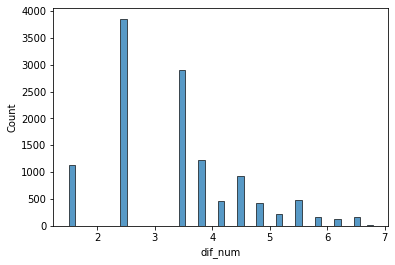

In [13]:
sns.histplot(df.dif_num)

Majority are 2 or 3 but dont have any 2-, 2+ or 3-. research shows this is the swiss hiking scale (URL) (SAC or Swiss Alpine Club scale). ratings on hikr.org only use finer scale with + and - symbols at grade 3 and above. 

Now let's explore the properties of the numeric parameters:

### Check for missing values

In [14]:
df.isnull().sum()

length_3d           0
user                0
max_elevation    1578
uphill              0
moving_time         0
difficulty          0
min_elevation    1578
downhill            0
length_2d           0
dif_num             0
dtype: int64

There's a lot of entries without elevation data. While these entries may have still been useful for our project based on other parameters, we see below that these entries often have moving times of 0 seconds. Therefore, we chose to remove them for the database. 

In [15]:
df[df.max_elevation.isnull()][:5]

,length_3d,user,max_elevation,uphill,moving_time,difficulty,min_elevation,downhill,length_2d,dif_num
43,0.000000,poudrieres,NaN,0.0,0.0,T6 - Difficult High-level Alpine hike,NaN,0.0,0.000000,6.5
86,0.000000,zaufen,NaN,0.0,0.0,T3 - Difficult Mountain hike,NaN,0.0,0.000000,3.5
87,0.000000,zaufen,NaN,0.0,0.0,T1 - Valley hike,NaN,0.0,0.000000,1.5
88,0.000000,zaufen,NaN,0.0,0.0,T3 - Difficult Mountain hike,NaN,0.0,0.000000,3.5
90,8906.247367,Riosambesi,NaN,0.0,0.0,T2 - Mountain hike,NaN,0.0,8906.247367,2.5


In [16]:
df = df.dropna()

In [17]:
df.shape

(10563, 10)

### Remove outliers

In [18]:
df.describe()

,length_3d,max_elevation,uphill,moving_time,min_elevation,downhill,length_2d,dif_num
count,1.056300e+04,10563.000000,10563.000000,10563.000000,10563.000000,10563.000000,1.056300e+04,10563.000000
mean,2.025524e+04,1934.281708,1082.936698,14671.965351,1003.331150,1010.480545,2.025524e+04,3.415810
std,4.387800e+05,784.968353,1073.528688,11295.319195,813.001041,1040.869888,4.387800e+05,1.154353
min,3.038565e+00,-1.000000,0.000000,0.000000,-32768.000000,0.000000,3.038565e+00,1.500000
25%,8.924436e+03,1382.275000,626.620892,8797.000000,560.020000,536.042000,8.924436e+03,2.500000
50%,1.242316e+04,1986.700000,980.800000,14251.000000,960.090000,927.190000,1.242316e+04,3.500000
75%,1.683374e+04,2498.455848,1368.169000,19291.000000,1389.485000,1338.298408,1.683374e+04,3.800000
max,3.189180e+07,5633.462891,35398.006781,189380.000000,4180.000000,52379.200000,3.189180e+07,6.800000


There are some suspicious values here. For example, there are still entries with a moving time of 0 seconds or negative max and min elevations. 

### Removing routes with very short distances
Remove any routes less than 500m

In [19]:
df[df["length_3d"] < 500]

,length_3d,user,max_elevation,uphill,moving_time,difficulty,min_elevation,downhill,length_2d,dif_num
45,3.903501,ser59,30.00,0.000,0.0,T3 - Difficult Mountain hike,30.00,0.000,3.903501,3.5
1149,3.038565,emely,2538.63,0.000,0.0,T2 - Mountain hike,2535.89,2.740,3.038565,2.5
4769,270.520262,quacamozza,2244.74,158.970,0.0,T6 - Difficult High-level Alpine hike,2085.77,0.000,270.520262,6.5
4847,343.393491,quacamozza,1834.99,37.823,350.0,T5 - Challenging High-level Alpine hike,1796.36,0.493,343.393491,5.5
5284,4.194346,DutchHikr,-1.00,0.000,0.0,T1 - Valley hike,-1.00,0.000,4.194346,1.5
6002,462.146938,quacamozza,919.89,0.000,239.0,T3 - Difficult Mountain hike,887.20,32.690,462.146938,3.5
8726,270.520262,quacamozza,2244.74,158.970,0.0,T6 - Difficult High-level Alpine hike,2085.77,0.000,270.520262,6.5
8796,343.393491,quacamozza,1834.99,37.823,350.0,T5 - Challenging High-level Alpine hike,1796.36,0.493,343.393491,5.5
9248,4.194346,DutchHikr,-1.00,0.000,0.0,T1 - Valley hike,-1.00,0.000,4.194346,1.5
9944,462.146938,quacamozza,919.89,0.000,239.0,T3 - Difficult Mountain hike,887.20,32.690,462.146938,3.5


In [20]:
df = df[df["length_3d"] >= 500]

### Remove entries without a moving time

If we look at the entries with the shortest times we see that some of these are unfeasible (or are not possible on foot). For example, entry 673 here which has a distance of over 25km but was walked in 5 seconds... 

In [21]:
df[df["moving_time"]<360][:5]

,length_3d,user,max_elevation,uphill,moving_time,difficulty,min_elevation,downhill,length_2d,dif_num
7,8389.371263,kopfsalat,723.400000,402.480000,0.0,T2 - Mountain hike,417.700000,393.380000,8389.371263,2.5
8,11481.637990,Mo6451,1061.999987,366.213306,0.0,T2 - Mountain hike,750.500003,365.513308,11481.637990,2.5
14,15515.559314,Felix,1649.600000,917.811089,0.0,T3 - Difficult Mountain hike,823.300002,868.411089,15515.559314,3.5
42,11694.677397,Mo6451,462.900000,31.440000,0.0,T1 - Valley hike,429.850000,31.380000,11694.677397,1.5
55,14010.842208,Felix,1495.200000,1120.521531,0.0,T2 - Mountain hike,425.700000,746.821531,14010.842208,2.5


We can remove these entries with very short moving times but we can also create a new column representing average speed which will help eliminate any entries which are unlikely to have been walked but are either mistakes or potentially driving routes. 

In [31]:
df = df[df["moving_time"]>600]

### Add average speed parameter

In [23]:
m_per_second =  df["length_3d"]/df["moving_time"]  
df["avg_speed_kmh"] = m_per_second*3600/1000 #km/h

In [24]:
df["avg_speed_kmh"].describe()

count    9682.000000
mean        5.326934
std       125.181610
min         1.607421
25%         2.639689
50%         2.968236
75%         3.459081
max      8710.963306
Name: avg_speed_kmh, dtype: float64

speed of over 18,000 km/h must be wrong! Let's check of the fastest entries. average running speed is around 10km/h

In [25]:
df[df["avg_speed_kmh"]> 10][:4]

,length_3d,user,max_elevation,uphill,moving_time,difficulty,min_elevation,downhill,length_2d,dif_num,avg_speed_kmh
26,5765.764594,83_Stefan,1713.00,1012.000000,2017.0,T3 - Difficult Mountain hike,685.00,0.000000,5765.764594,3.5,10.290904
99,8625.811749,83_Stefan,2787.00,782.300000,3011.0,T6 - Difficult High-level Alpine hike,2013.00,782.300000,8625.811749,6.5,10.313159
117,13123.487634,83_Stefan,1057.00,688.300000,4686.0,T2 - Mountain hike,397.00,678.300000,13123.487634,2.5,10.082065
196,39451.072935,gbal,832.64,123.412875,12078.0,T1 - Valley hike,202.49,732.892875,39451.072935,1.5,11.758889


In [26]:
df = df[df["avg_speed_kmh"] < 10]

### Remove anomalous elevations
While can get land below sea level 32km below is not possible! Let's sort those out

In [42]:
df = df[df["min_elevation"] >-50]
df = df[df["max_elevation"] >0]

In [43]:
df.describe()

,length_3d,max_elevation,uphill,moving_time,min_elevation,downhill,length_2d,dif_num,avg_speed_kmh
count,9420.000000,9420.000000,9420.000000,9420.000000,9420.000000,9420.000000,9420.000000,9420.000000,9420.000000
mean,14139.609555,1971.327386,1105.647950,16236.224628,1023.121531,1044.601957,14139.609555,3.461327,3.228177
std,10536.323362,768.427532,938.605409,10724.345503,574.194013,1064.692347,10536.323362,1.153834,1.136423
min,651.600628,5.190000,0.000000,681.000000,-49.420000,0.000000,651.600628,1.500000,1.607421
25%,9066.954914,1438.895000,664.786500,10726.000000,573.560000,583.782250,9066.954914,2.500000,2.633136
50%,12573.585526,2016.069998,1019.335000,15219.000000,974.655000,965.806000,12573.585526,3.500000,2.949956
75%,16955.282533,2512.060000,1394.409500,19975.000000,1400.960002,1368.089000,16955.282533,4.200000,3.404393
max,226907.816848,5633.462891,29286.167000,189380.000000,4180.000000,52379.200000,226907.816848,6.800000,9.994365


In [41]:
df[df["max_elevation"] <=0]

,length_3d,user,max_elevation,uphill,moving_time,difficulty,min_elevation,downhill,length_2d,dif_num,avg_speed_kmh
1966,8803.720863,Bombo,0.0,0.0,3180.0,T6- - Difficult High-level Alpine hike,0.0,0.0,8803.720863,6.2,9.966476
2925,9478.857877,BergfloHD,0.0,0.0,12390.0,T4 - High-level Alpine hike,0.0,0.0,9478.857877,4.5,2.754148
6811,9478.857877,BergfloHD,0.0,0.0,12390.0,T4 - High-level Alpine hike,0.0,0.0,9478.857877,4.5,2.754148
